We want to copy the weights for the HiFiGAN from the XTTS model and check that our model spits out the same thing as a sanity check

We first download TTS, and the model checkpoint for XTTS.

In [1]:
!wget "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/model.pth"
!wget "https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/config.json"

--2024-11-09 12:05:45--  https://coqui.gateway.scarf.sh/hf-coqui/XTTS-v2/main/model.pth
Resolving coqui.gateway.scarf.sh (coqui.gateway.scarf.sh)... 3.77.103.135, 3.67.33.93
Connecting to coqui.gateway.scarf.sh (coqui.gateway.scarf.sh)|3.77.103.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://huggingface.co/coqui/XTTS-v2/resolve/main/model.pth [following]
--2024-11-09 12:05:45--  https://huggingface.co/coqui/XTTS-v2/resolve/main/model.pth
Resolving huggingface.co (huggingface.co)... 2600:9000:244f:7000:17:b174:6d00:93a1, 2600:9000:244f:7400:17:b174:6d00:93a1, 2600:9000:244f:de00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:244f:7000:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/3e/73/3e73be38940b0ce7d10274a3412defcd0d3c9ea879d08bc8761d46cf6bbde3fa/c7ea20001c6a0a841c77e252d8409f6a74fb423e79b3206a0771ba5989776187?response-content-

In [ ]:
!git clone git@github.com:nguyenhoanganh2002/XTTSv2-Finetuning-for-New-Languages.git
!mv XTTSv2-Finetuning-for-New-Languages/* .

We should now be able to load the model as it is used in the XTTSv2.

In [1]:
from TTS.tts.layers.xtts.dvae import DiscreteVAE
import jax
import torch
import equinox as eqx
import pprint as pp

# Exported from .ipynb using python3 export.py (Exports all cells with the export tag)
from TTS.tts.layers.xtts.trainer.gpt_trainer import (
    GPTArgs,
    GPTTrainerConfig,
    GPTTrainer,
    XttsAudioConfig,
)
from TTS.tts.models.xtts import Xtts
from HiFiGAN_for_XTTS import Generator

# init args and config
model_args = GPTArgs(
    max_conditioning_length=132300,  # 6 secs
    min_conditioning_length=11025,  # 0.5 secs
    debug_loading_failures=False,
    max_wav_length=255995,  # ~11.6 seconds
    max_text_length=200,
    mel_norm_file="./mel_stats",
    dvae_checkpoint="",
    xtts_checkpoint="./model.pth",  # checkpoint path of the model that you want to fine-tune
    tokenizer_file="",
    gpt_num_audio_tokens=1026,
    gpt_start_audio_token=1024,
    gpt_stop_audio_token=1025,
    gpt_use_masking_gt_prompt_approach=True,
    gpt_use_perceiver_resampler=True,
)
audio_config = XttsAudioConfig(
    sample_rate=22050, dvae_sample_rate=22050, output_sample_rate=24000
)

config = GPTTrainerConfig()

config.load_json("./config.json")

config.epochs = 1
config.model_args = model_args
config.audio = audio_config
config.num_loader_workers = 8
config.eval_split_max_size = 256
config.print_step = 50
config.plot_step = 100
config.log_model_step = 100
config.save_n_checkpoints = 1
config.save_checkpoints = True
config.print_eval = False
config.optimizer = "AdamW"
config.optimizer_params = {"betas": [0.9, 0.96], "eps": 1e-8, "weight_decay": 1}
config.test_sentences = []

their_hifigan = Xtts(config).hifigan_decoder.waveform_decoder
# init the model from config

# Take all the params for the torch model. Print them and map them to our model.

torch_params = {
    name: param.detach().numpy() for name, param in their_hifigan.named_parameters()
}

# for x in torch_params:
#     print(x)
#     print(torch_params[x].shape)
# print(v)


def boop(path, a):
    seq = [str(p).strip("[].") for p in path]
    print(".".join(seq))
    print(a.shape)


key = jax.random.PRNGKey(1)
our_hifigan = Generator(1024, 1, key=key)
test = jax.tree_util.tree_map_with_path(lambda x, a: boop(x, a), our_hifigan)
their_hifigan.conv_pre

/Users/tugdual/miniconda3/envs/xtts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


conv_pre.weight
(512, 1024, 7)
conv_pre.bias
(512, 1)
layers.0.0.weight
(256, 512, 16)
layers.0.0.bias
(256, 1)
layers.0.1.weight
(256, 512, 1)
layers.0.1.bias
(256, 1)
layers.0.2.resblocks.0.conv_dil.0.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_dil.0.bias
(256, 1)
layers.0.2.resblocks.0.conv_dil.1.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_dil.1.bias
(256, 1)
layers.0.2.resblocks.0.conv_dil.2.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_dil.2.bias
(256, 1)
layers.0.2.resblocks.0.conv_straight.0.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_straight.0.bias
(256, 1)
layers.0.2.resblocks.0.conv_straight.1.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_straight.1.bias
(256, 1)
layers.0.2.resblocks.0.conv_straight.2.weight
(256, 256, 3)
layers.0.2.resblocks.0.conv_straight.2.bias
(256, 1)
layers.0.2.resblocks.1.conv_dil.0.weight
(256, 256, 7)
layers.0.2.resblocks.1.conv_dil.0.bias
(256, 1)
layers.0.2.resblocks.1.conv_dil.1.weight
(256, 256, 7)
layers.0.2.resblocks.1.co

Conv1d(1024, 512, kernel_size=(7,), stride=(1,), padding=(3,))

In [7]:
torch_to_jax_keys = {
    ("conv_pre.weight", "conv_pre.weight"),
    ("conv_pre.bias", "conv_pre.bias"),
    ("cond_layer.bias", "cond_layer.bias"),
    ("cond_layer.weight", "cond_layer.weight"),
    ("post_magic.weight", "conv_post.weight"),
}


# Function to update the JAX model parameters
def update_params(path, x):
    seq = [str(p).strip("[].") for p in path]
    # print(seq)
    if seq[0] == "layers" and seq[2] == "0":
        if seq[-1] == "weight":
            # Have to permute for transpose
            arr = jax.numpy.array(
                torch_params[
                    ".".join(
                        [
                            "ups",
                            seq[1],
                            "parametrizations",
                            seq[-1],
                            "original1",
                        ]
                    )
                ]
            )
            print(f"before: {arr.shape}")
            arr = jax.numpy.flip(arr, axis=2)
            arr = jax.numpy.swapaxes(arr, axis1=0, axis2=1)
            print(arr.shape)
            print(x.shape)
            return arr
        elif seq[-1] == "bias":
            return jax.numpy.expand_dims(
                torch_params[".".join(["ups", seq[1], seq[-1]])],
                -1,
            )
    if seq[0] == "layers" and seq[2] == "1":
        if seq[-1] == "weight":
            return jax.numpy.array(
                torch_params[
                    ".".join(
                        [
                            "conds",
                            seq[1],
                            seq[-1],
                        ]
                    )
                ]
            )
        elif seq[-1] == "bias":
            return jax.numpy.expand_dims(
                torch_params[".".join(["conds", seq[1], seq[-1]])],
                -1,
            )
    if seq[0] == "layers":
        index = str((int(seq[1]) * 3 + int(seq[4])))
        if seq[5] == "conv_dil":
            if seq[-1] == "weight":

                return jax.numpy.array(
                    torch_params[
                        ".".join(
                            [
                                "resblocks",
                                index,
                                "convs1",
                                seq[6],
                                "parametrizations",
                                seq[-1],
                                "original1",
                            ]
                        )
                    ]
                )
            elif seq[-1] == "bias":
                return jax.numpy.expand_dims(
                    torch_params[
                        ".".join(
                            [
                                "resblocks",
                                index,
                                "convs1",
                                seq[6],
                                seq[-1],
                            ]
                        )
                    ],
                    -1,
                )
        if seq[5] == "conv_straight":
            if seq[-1] == "weight":
                return jax.numpy.array(
                    torch_params[
                        ".".join(
                            [
                                "resblocks",
                                index,
                                "convs2",
                                seq[6],
                                "parametrizations",
                                seq[-1],
                                "original1",
                            ]
                        )
                    ]
                )
            elif seq[-1] == "bias":
                return jax.numpy.expand_dims(
                    torch_params[
                        ".".join(
                            [
                                "resblocks",
                                index,
                                "convs2",
                                seq[6],
                                seq[-1],
                            ]
                        )
                    ],
                    -1,
                )
    seq = ".".join(seq)
    for jax_key, torch_key in torch_to_jax_keys:
        if jax_key == seq:
            print(seq + " " + torch_key)
            if "bias" in jax_key:
                return jax.numpy.expand_dims(torch_params[torch_key], -1)
            return jax.numpy.array(torch_params[torch_key])
    return x


# Grab the checky ones that don't have a name but that we need
# torch_params["dvae.codebook.embed"] = dvae.codebook.embed
# dvae.load_state_dict(torch.load(dvae_pretrained), strict=False)
# print(list(dvae.decoder.state_dict()))
# Updatorche the JAX model parameters
our_hifigan = jax.tree_util.tree_map_with_path(update_params, our_hifigan)
eqx.tree_serialise_leaves("./xttshifigan.eqx", our_hifigan)
# Replace the encoder in the model with the updated encoder
# model = eqx.tree_at(lambda m: m, model, model)
# print(model.quantizer.codebook.shape)
# eqx.tree_serialise_leaves("./xttsvqvae.eqx", model)

conv_pre.weight conv_pre.weight
conv_pre.bias conv_pre.bias
before: (512, 256, 16)
(256, 512, 16)
(256, 512, 16)
before: (256, 128, 16)
(128, 256, 16)
(128, 256, 16)
before: (128, 64, 4)
(64, 128, 4)
(64, 128, 4)
before: (64, 32, 4)
(32, 64, 4)
(32, 64, 4)
post_magic.weight conv_post.weight
cond_layer.weight cond_layer.weight
cond_layer.bias cond_layer.bias


Below are chaotic tests I made to check things worked, progressively going through the model.

In [ ]:
import numpy as np

x = torch.ones((1, 1024, 960))
g = torch.ones((1, 512, 1))
x1 = jax.numpy.array(x.numpy())
g1 = jax.numpy.array(
    g.numpy()
)  # Convert PyTorch tensor to numpy array before converting to JAX array
torch.testing.assert_close(x, torch.from_numpy(np.array(x1)))

y = their_hifigan.conv_pre(x)
y1 = jax.vmap(our_hifigan.norm(our_hifigan.conv_pre))(x1)

torch.testing.assert_close(y, torch.from_numpy(np.array(y1)))


# y += their_hifigan.cond_layer(g)
# y1 += jax.vmap(our_hifigan.cond_layer)(g1)

y = their_hifigan(x, g)
y1 = jax.vmap(our_hifigan)(x1, g1)

# torch.testing.assert_close(y, torch.from_numpy(np.array(y1)))

# y = torch.nn.functional.leaky_relu(y, 0.1)
# y1 = jax.nn.leaky_relu(y1, 0.1)
torch.testing.assert_close(y, torch.from_numpy(np.array(y1)))

# y = their_hifigan.ups[0](y)
# y1 = jax.vmap(our_hifigan.norm(our_hifigan.layers[0][0]))(y1)

# # y = their_hifigan(x, g)
# # y1 = jax.vmap(our_hifigan)(x1, g1)

# torch.testing.assert_close(y, torch.from_numpy(np.array(y1)))


# print(dvae.encoder[1][0])
# print(model.encoder.conv1)
# y = dvae.encoder[0](x)  # Apply the encoder to the input tensor
# y = dvae.encoder[1][0](y)  # Apply the encoder to the input tensor
# y1 = jax.vmap(model.encoder.conv1)(x1)
# y1 = jax.vmap(jax.nn.relu)(y1)
# y1 = jax.vmap(model.encoder.conv2)(y1)
# y1 = jax.vmap(jax.nn.relu)(y1)

# Convert JAX array back to numpy array and then to PyTorch tensor for comparison
# torch.testing.assert_close(y, torch.from_numpy(np.array(y1)))

Avg diff: -0.0124506251886487


AssertionError: Tensor-likes are not close!

Mismatched elements: 245760 / 245760 (100.0%)
Greatest absolute difference: 0.031505972146987915 at index (0, 0, 245751) (up to 1e-05 allowed)
Greatest relative difference: 0.059801895171403885 at index (0, 0, 245751) (up to 1.3e-06 allowed)

Although there still is a difference, it's low enough that we musn't waste too much time on it. I suspect it comes from the bias at the last layer conv...

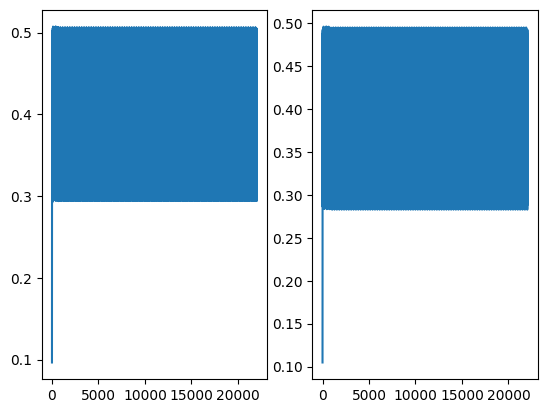

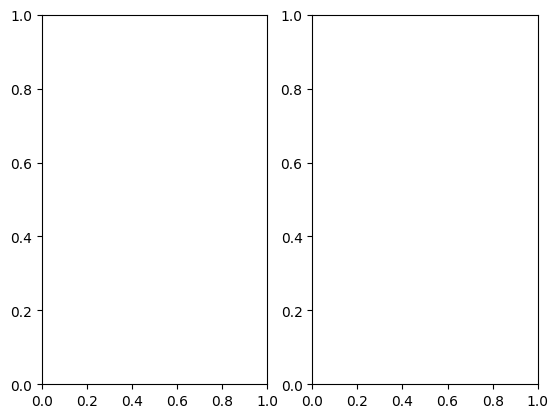

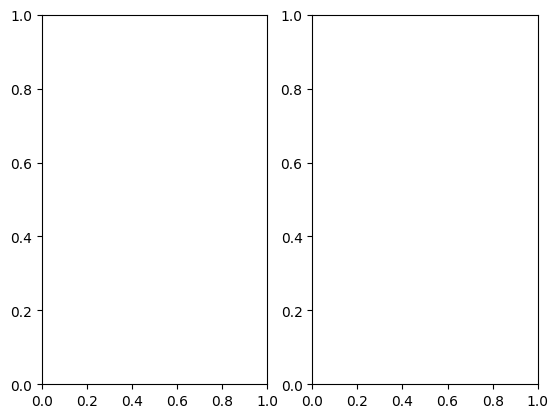

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104ec0a30>>
Traceback (most recent call last):
  File "/Users/tugdual/miniconda3/envs/xtts/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
%matplotlib inline
from IPython.display import display, Markdown

import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(y[0, 0, :22050].detach().numpy())
ax2.plot(y1[0, 0, :22050])
display(fig)
plt.show()

In [ ]:
print(their_hifigan.cond_layer)
print(our_hifigan.cond_layer)

Conv1d(512, 512, kernel_size=(1,), stride=(1,))
Conv1d(
  num_spatial_dims=1,
  weight=f32[512,512,1],
  bias=f32[512,1],
  in_channels=512,
  out_channels=512,
  kernel_size=(1,),
  stride=(1,),
  padding=((0, 0),),
  dilation=(1,),
  groups=1,
  use_bias=True,
  padding_mode='ZEROS'
)


In [ ]:
import numpy as np
import jax.numpy as jnp

x = torch.ones((1, 80, 300))
x1 = jax.numpy.array(x.numpy(), dtype=jnp.float64)[
    0
]  # Convert PyTorch tensor to numpy array before converting to JAX array
# torch.testing.assert_close(x, torch.from_numpy(np.array(x1)))

input = dvae.encoder(x).permute((0, 2, 1))  # Apply the encoder to the input tensor
print(input.shape)
flatten = input.reshape(-1, 512)
print(flatten.shape)
a_squared = flatten.pow(2).sum(1, keepdim=True)
print(a_squared.shape)
print(f"Their codebook shape{dvae.codebook.embed.shape}")

b_squared = dvae.codebook.embed.pow(2).sum(0, keepdim=True)
print(b_squared.shape)
dist = a_squared - 2 * flatten @ dvae.codebook.embed + b_squared
soft_codes = -dist
_, embed_ind = soft_codes.max(1)
embed_onehot = torch.nn.functional.one_hot(embed_ind, dvae.codebook.n_embed).type(
    flatten.dtype
)
embed_ind = embed_ind.view(*input.shape[:-1])
y = dvae.codebook.embed_code(embed_ind)
print(y.shape)
y = y.permute((0, 2, 1))
print(y.shape)
print(f"My codebook shape{model.quantizer.codebook.shape}")
y1 = model.encoder(x1)
y1 = jax.numpy.permute_dims(y1, (1, 0))
print(y1.shape)
flatten = jax.numpy.reshape(y1, (-1, model.quantizer.D))
a_squared = jnp.sum(jnp.pow(flatten, 2), axis=-1, keepdims=True)
print(a_squared.shape)
b_squared = jnp.sum(jnp.pow(model.quantizer.codebook, 2), axis=0, keepdims=True)
print(b_squared.shape)
distance = a_squared + b_squared - 2 * jnp.matmul(flatten, model.quantizer.codebook)


codebook_indices = jnp.argmin(distance, axis=-1)
torch.testing.assert_close(
    embed_ind[0], torch.from_numpy(np.array(codebook_indices)).to(torch.int64)
)
# codebook_onehot = jax.nn.one_hot(codebook_indices, self.K)
z_q = model.quantizer.codebook.T[codebook_indices]
# Straight-through estimator
print(z_q.shape)
z_q = flatten + jax.lax.stop_gradient(z_q - flatten)
y1 = jax.numpy.permute_dims(z_q, (1, 0))

print(y.shape)
# y1, _ = jax.vmap(model.quantizer)(y1)
# y = dvae.encoder[1](y)  # Apply the encoder to the input tensor
# y1 = jax.vmap(jax.nn.relu)(y1)
# y1 = jax.vmap(model.encoder.conv2)(y1)
# y1 = jax.vmap(jax.nn.relu)(y1)

# y1 = jax.vmap(jax.nn.relu)(y1)

# Convert JAX array back to numpy array and then to PyTorch tensor for comparison
torch.testing.assert_close(y[0], torch.from_numpy(np.array(y1)))

In [ ]:
import numpy as np
import jax.numpy as jnp

x = torch.ones((1, 80, 300))
x1 = jax.numpy.array(x.numpy(), dtype=jnp.float64)[
    0
]  # Convert PyTorch tensor to numpy array before converting to JAX array
# torch.testing.assert_close(x, torch.from_numpy(np.array(x1)))

input = dvae.encoder(x).permute((0, 2, 1))  # Apply the encoder to the input tensor
y = dvae.codebook(input)[0]
y = y.permute((0, 2, 1))
y = dvae.decoder(y)
y1 = model.encoder(x1)
y1, _ = model.quantizer(y1)
y1 = model.decoder(y1)
print(y.shape)
# y1, _ = jax.vmap(model.quantizer)(y1)
# y = dvae.encoder[1](y)  # Apply the encoder to the input tensor
# y1 = jax.vmap(jax.nn.relu)(y1)
# y1 = jax.vmap(model.encoder.conv2)(y1)
# y1 = jax.vmap(jax.nn.relu)(y1)

# y1 = jax.vmap(jax.nn.relu)(y1)

# Convert JAX array back to numpy array and then to PyTorch tensor for comparison
torch.testing.assert_close(y[0], torch.from_numpy(np.array(y1)))